In [1]:
import cv2
import numpy as np
import os
from PIL import Image
import huffman 

In [2]:
def psnr(original, compressed):
    # Convert images to numpy arrays
    original_array = np.array(original)
    compressed_array = np.array(compressed)

    # Ensure both images have the same shape and data type
    if original_array.shape != compressed_array.shape or original_array.dtype != compressed_array.dtype:
        raise ValueError("Both images must have the same shape and data type.")

    # Calculate the mean squared error
    mse = np.mean((original_array - compressed_array) ** 2)

    # Calculate the peak signal-to-noise ratio (PSNR)
    max_pixel_value = 255  # For 8-bit images
    psnr_value = 10 * np.log10((max_pixel_value ** 2) / mse)

    return psnr_value

def calculate_probabilities(data):
    unique_values, counts = np.unique(data, return_counts=True)
    probabilities = counts / len(data)
    return zip(unique_values, probabilities/8)

def huffman_decode_line(encoded_line, huffman_mapping):
    decoded_line = ''
    current_code = ''

    for bit in encoded_line:
        current_code += bit
        for symbol, code in huffman_mapping.items():
            if current_code == code:
                # decoded_line += str(symbol) + ' '
                current_code = ''
                break

    return decoded_line.strip()

def combine_and_convert_to_uint8(inv_dct_blocks, height, width, block_size):
    reconstructed_image = np.zeros((height, width), dtype=np.float32)

    for i, (row, col) in enumerate([(i, j) for i in range(0, height, block_size) for j in range(0, width, block_size)]):
        reconstructed_image[row:row + block_size, col:col + block_size] = inv_dct_blocks[i]

    # Convert the reconstructed image back to uint8
    reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)

    return reconstructed_image

def encode_with_huffman(data, huffman_mappings):
    encoded_data = ""
    for value in data:
        encoded_data += huffman_mappings[value]
    return encoded_data

def combine(inv_dct_blocks, height, width, block_size):
    reconstructed_image = np.zeros((height, width), dtype=np.float32)

    for i, (row, col) in enumerate([(i, j) for i in range(0, height, block_size) for j in range(0, width, block_size)]):
        reconstructed_image[row:row + block_size, col:col + block_size] = inv_dct_blocks[i]

    return reconstructed_image

def decode_with_huffman(encoded_data, huffman_mappings):
    reverse_mappings = {v: k for k, v in huffman_mappings.items()}
            
    decoded_data = []
    current_code = ""
            
    for bit in encoded_data:
        current_code += bit
        if current_code in reverse_mappings:
            # decoded_data.append(reverse_mappings[current_code])
            current_code = ""
            
    return decoded_data

def calculate_average_length(probability, huffman_code):
    average_length = 0.0

    for symbol, prob in probability:
        code = huffman_code[symbol]
        average_length += len(code) * prob

    return average_length

In [3]:
# Load image
image_path = "image.jpg"
original_image = cv2.imread(image_path)
# Convert RGB image to Gray image
grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
cv2.imwrite('Grayscale image.jpg',grayscale_image)

True

In [4]:
# Divide image into 8x8 macro blocks
block_size = 8
height, width = grayscale_image.shape[:2]
macro_blocks = [grayscale_image[i:i + block_size, j:j + block_size] for i in range(0, height, block_size) for j in range(0, width, block_size)]

In [5]:
 # Apply DCT to each block
dct_macro_blocks = [cv2.dct(np.float32(block)) for block in macro_blocks]

In [6]:
# Quantization matrix

quantization_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                            [12, 12, 14, 19, 26, 58, 60, 55],
                                            [14, 13, 16, 24, 40, 57, 69, 56],
                                            [14, 17, 22, 29, 51, 87, 80, 62],
                                            [18, 22, 37, 56, 68, 109, 103, 77],
                                            [24, 35, 55, 64, 81, 104, 113, 92],
                                            [49, 64, 78, 87, 103, 121, 120, 101],
                                            [72, 92, 95, 98, 112, 100, 103, 99]])

# Get 3 quantization levels by multiply the matrix with factor
factor = 0.5
quantization_matrix_2 = np.round(quantization_matrix * factor).astype(int)  
quantization_matrix_3 = np.round(quantization_matrix / factor).astype(int) 

# Get the quantized blocks
quantized_blocks_1 = [np.round(dct_block / quantization_matrix) for dct_block in dct_macro_blocks]    # Normal quality (Level 1)
quantized_blocks_2 = [np.round(dct_block / quantization_matrix_2) for dct_block in dct_macro_blocks]  # improve quality (Level 3)
quantized_blocks_3 = [np.round(dct_block / quantization_matrix_3) for dct_block in dct_macro_blocks]  # reduce quality (Level 3)

In [9]:
# Select the quantization level 
# 1. High quality
# 2. Medium quality
# 3. Low quality

a = int(input('----Enter Quantization level----\n1.High Quality\n2.Medium Quality\n3.Low Quality\nEnter the number: '))
if a==1:
    quantized_block = quantized_blocks_2
elif a==2:
    quantized_block = quantized_blocks_1
elif a==3:
    quantized_block = quantized_blocks_3
else:
    print("Try again. Enter number 1, 2 or 3")

# Quantization blocks are recombine to take the huffman mapping    
re_img = combine(quantized_block, height, width, block_size)
flat_re_img = re_img.flatten()
prob_re_img = list(calculate_probabilities(flat_re_img))
huffman_mappings_re_img = huffman.codebook(prob_re_img)

# 'output_file.txt' is the file where you want to save the encoded data
output_file_path = 'output_file.txt'

# Encode the flattened image using Huffman mappings
encoded_data_re = encode_with_huffman(flat_re_img, huffman_mappings_re_img)
# Write the encoded data to a text file
with open(output_file_path, 'w') as output_file:
    output_file.write(encoded_data_re)

# 'output_file.txt' contains the encoded data
input_file_path_re = 'output_file.txt'
# Read the encoded data from the text file
with open(input_file_path_re, 'r') as input_file:
    encoded_data = input_file.read()

# Decode the data using Huffman mappings
decoded_data = decode_with_huffman(encoded_data, huffman_mappings_re_img)

# Reshape the decoded data to its original shape   
decoded_img = np.array(decoded_data).reshape(height, width)

# Again make the blocks of decoded image
macro_blocks_re = [decoded_img[i:i + block_size, j:j + block_size] for i in range(0, height, block_size) for j in range(0, width, block_size)]

# Dequantized the blocks
dequantized_blocks = [np.multiply(block, quantization_matrix) for block in macro_blocks_re]

# Get the inverse DCT of the dequantized blocks
inv_dct_blocks = [cv2.idct(np.float32(block)) for block in dequantized_blocks]

# Reconstruct the image
reconstructed_image= combine_and_convert_to_uint8(inv_dct_blocks, height, width, block_size)
# Save the reconstructed image
cv2.imwrite("Reconstructed image.jpg", reconstructed_image)

# Take the average length of encoded files
average_len = calculate_average_length(prob_re_img, huffman_mappings_re_img)
print(f"Average Length: {average_len}")

# Calculate the compression ratio
input_image_size = height*width*8
compressed_size = height*width*average_len
# compression_ratio = input_image_size /compressed_size
print('Compression Ratio',compression_ratio)

# Calculate the bitrate (for fps = 1)
current_bitrate = len(encoded_data)
print("Current bitrate", current_bitrate/1000,'kbps')

# Calculate the psnr of the image
input_image_path = 'Grayscale image.jpg'
compressed_image_path = 'reconstructed image.jpg'
original_image = Image.open(input_image_path)
compressed_image = Image.open(compressed_image_path)
print('psnr value is', psnr(original_image, compressed_image))

cv2.waitKey(0)
cv2.destroyAllWindows()

Average Length: 0.19532089795761678
Compression Ratio 40.958238896361934
Current bitrate 814.035 kbps
psnr value is 33.297837451705576


Adjust the Compression ratio for a target Bitrate

E-no = 268

Target bitrate = e-no + 300 = 268 +300 = 568 kbps

CR =  41.968586598324855 , Factor =  1.1 , psnr =  33.206120594157724 , Bitrate =  794.438 kbps
CR =  42.9608459854476 , Factor =  1.2 , psnr =  33.09748135710328 , Bitrate =  776.089 kbps
CR =  43.90584486130223 , Factor =  1.3 , psnr =  33.004035586487724 , Bitrate =  759.385 kbps
CR =  44.7089018364186 , Factor =  1.4 , psnr =  32.926433788139946 , Bitrate =  745.745 kbps
CR =  45.47969870659906 , Factor =  1.5 , psnr =  32.85823087393228 , Bitrate =  733.106 kbps
CR =  46.10118870666447 , Factor =  1.6 , psnr =  32.791069578761046 , Bitrate =  723.223 kbps
CR =  46.71102200815096 , Factor =  1.7 , psnr =  32.72725637288258 , Bitrate =  713.781 kbps
CR =  47.34957502254476 , Factor =  1.8 , psnr =  32.670687349469645 , Bitrate =  704.155 kbps
CR =  47.85822863302763 , Factor =  1.9 , psnr =  32.6055267247238 , Bitrate =  696.671 kbps
CR =  48.34573099822228 , Factor =  2.0 , psnr =  32.55545748917515 , Bitrate =  689.646 kbps
CR =  48.80415944540729 , Factor =  2.1 , psnr =  32.4903

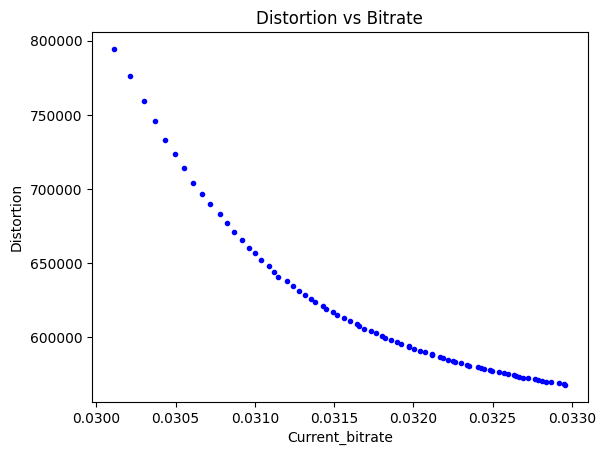

In [11]:
# Function for adjust the compression ratio

import matplotlib.pyplot as plt

def adjust_compression_ratio( img,output_file_path, target_bitrate, current_bitrate,output_folder):

    # Convert RGB image to Gray image
    block_size = 8
    height, width = img.shape[:2]
    macro_blocks = [img[i:i + block_size, j:j + block_size] for i in range(0, height, block_size) for j in range(0, width, block_size)]  
    dct_macro_blocks = [cv2.dct(np.float32(block)) for block in macro_blocks]  
   
    factor = 1
    original_quantization_matrix = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                                            [12, 12, 14, 19, 26, 58, 60, 55],
                                            [14, 13, 16, 24, 40, 57, 69, 56],
                                            [14, 17, 22, 29, 51, 87, 80, 62],
                                            [18, 22, 37, 56, 68, 109, 103, 77],
                                            [24, 35, 55, 64, 81, 104, 113, 92],
                                            [49, 64, 78, 87, 103, 121, 120, 101],
                                            [72, 92, 95, 98, 112, 100, 103, 99]])    

    # Adjust quality by changing the factor until the resulting file size is close to the target bitrate
    while current_bitrate > target_bitrate and 0 < factor:
        factor += 0.1
        quantization_matrix1 = np.copy(original_quantization_matrix)
        quantization_matrix = np.round(quantization_matrix1 * factor).astype(int)   
        quantized_blocks = [np.round(dct_block / quantization_matrix) for dct_block in dct_macro_blocks]
        re_img = combine(quantized_blocks, height, width, block_size)
        flat_re_img = re_img.flatten()
        # prob_re_img = list(calculate_probabilities(flat_re_img))
        # huffman_mappings_re_img = huffman.codebook(prob_re_img)

        # Assuming 'output_file.txt' is the file where you want to save the encoded data
        output_file_path = encode_path

        # Encode the flattened image using Huffman mappings
        encoded_data_re = encode_with_huffman(flat_re_img, huffman_mappings_re_img)

        # Write the encoded data to a text file
        with open(output_file_path, 'w') as output_file:
            output_file.write(encoded_data_re)

        # Assuming 'output_file.txt' contains the encoded data
        input_file_path_re = encode_path

        # Read the encoded data from the text file
        with open(input_file_path_re, 'r') as input_file:
            encoded_data_re = input_file.read()

        # Decode the data using Huffman mappings
        decoded_data = decode_with_huffman(encoded_data_re, huffman_mappings_re_img)

        # Reshape the decoded data to its original shape     
        decoded_img = np.array(decoded_data).reshape(height, width)

        macro_blocks_re = [decoded_img[i:i + block_size, j:j + block_size] for i in range(0, height, block_size) for j in range(0, width, block_size)]
        dequantized_blocks = [np.multiply(block, quantization_matrix) for block in macro_blocks_re]
        inv_dct_blocks = [cv2.idct(np.float32(block)) for block in dequantized_blocks]
        # reconstructed_image_adjusted = combine_and_convert_to_uint8(inv_dct_blocks, height, width, block_size)

        # cv2.imwrite(os.path.join(output_folder, f'quality_{factor}.png'), reconstructed_image_adjusted)

        # average_len = calculate_average_length(prob_re_img, huffman_mappings_re_img)

        input_image_size = height*width*8
        compressed_size = height*width* average_len
        # compression_ratio_adjust = input_image_size /compressed_size
     
        current_bitrate = len(encoded_data_re)

        # Calculate the psnr of the image
        input_image_path = 'Grayscale image.jpg'
        compressed_image_path = os.path.join(output_folder, f'quality_{factor}.png')
        original_image = Image.open(input_image_path)
        compressed_image = Image.open(compressed_image_path)
        psnr_i = psnr(original_image, compressed_image)

        plt.plot((1/psnr_i), current_bitrate, '.', color='blue')
        plt.ylabel('Distortion')
        plt.xlabel('Current_bitrate')
        plt.title('Distortion vs Bitrate')
       
        print('CR = ',compression_ratio_adjust,', Factor = ',round(factor, 2),', psnr = ',psnr_i, ', Bitrate = ', current_bitrate/1000,'kbps')

    cv2.imwrite("adjested_img.jpg", reconstructed_image_adjusted)
    print(f"Adjusted compression ratio is {compression_ratio_adjust}. Target bitrate: {target_bitrate/1000} kbps, Current bitrate : {current_bitrate/1000} kbps")
    plt.show()
    
img = grayscale_image
bitrate_1 = int(input('Enter the target bitrate (kbps): '))  # E-no+300 --> 268+300 kbps = 568 kbps
target_bitrate = bitrate_1 * 1000
encode_path = "encoded_data_adjust.txt"

# Create a folder to save frames
output_folder = 'Adjusted_images'
os.makedirs(output_folder, exist_ok=True)

# Run the function of adjusting compression raio
adjust_compression_ratio(img,encode_path,target_bitrate,current_bitrate,output_folder)